## Trends in programming languages and licences

In [1]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F

from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
# import pyspark functions and data types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, DoubleType, BooleanType
from pyspark.sql.functions import col, element_at, count, countDistinct, avg, split, array_contains, isnan, when

In [3]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [4]:
gcs_folder = 'gs://msca-bdp-students-bucket/shared_data/esmyslovskikh/whole_df.parquet/'

df = spark.read \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .parquet(gcs_folder)

In [5]:
df = df.withColumn("commit_time", col("commit_time").cast("timestamp"))
df = df.withColumn("commit_day", split(df["commit_time"], " ")[0])
# year column
df = df.withColumn("commit_year", split(df["commit_day"], "-")[0])
#df = df.withColumn("commit_time", col("commit_time").cast("int"))
df = df.withColumn("commit_year", col("commit_year").cast(IntegerType()))
#df.cache()

In [6]:
df = df.filter((df['commit_day'] >= '2008-01-01') & (df['commit_day'] <= '2023-01-01'))

In [10]:
grouped_language = df.groupby('language_new').agg(count('*')).orderBy('count(1)', ascending=False)
grouped_language = grouped_language.limit(10).toPandas()
grouped_language

,language_new,count(1)
0,CSS,298310
1,C,129841
2,Batchfile,101843
3,None,65225
4,HTML,59447
5,JavaScript,59152
6,Python,50181
7,Assembly,50025
8,Java,46899
9,Dockerfile,26569


In [17]:
most_popular_languages = list(grouped_language['language_new'])
most_popular_languages

['CSS',
 'C',
 'Batchfile',
 None,
 'HTML',
 'JavaScript',
 'Python',
 'Assembly',
 'Java',
 'Dockerfile']

In [23]:
df_grouped_y = df.groupby('commit_year', 'language_new').agg(count('*'))
df_grouped_y = df_grouped_y.filter(df_grouped_y.language_new.isin(most_popular_languages))
df_grouped_y = df_grouped_y.withColumn("count(1)", col("count(1)").cast(IntegerType()))
df_grouped_y = df_grouped_y.toPandas()
df_grouped_y = df_grouped_y.rename({"count(1)": "Commits", "commit_year": "Year", "language_new": "Language"}, axis=1)
df_grouped_y

,Year,Language,Commits
0,2013,Python,3776
1,2021,Dockerfile,2499
2,2012,Python,2118
3,2013,Batchfile,5974
4,2011,Dockerfile,114
...,...,...,...
130,2022,Batchfile,2987
131,2010,CSS,4610
132,2010,Assembly,3775
133,2020,Assembly,2878


In [24]:
# Import seaborn
import seaborn as sns

# Apply the default theme
sns.set_theme(style="darkgrid")

<AxesSubplot:xlabel='Year', ylabel='Commits'>

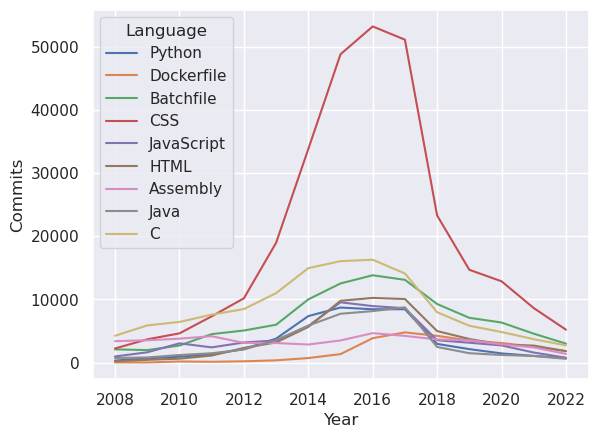

In [26]:
sns.lineplot(x="Year", y="Commits",
             hue="Language",
             data=df_grouped_y)

## Distribution of licenses across repositories

In [31]:
grouped_licenses = df.groupby('license').agg(count('*')).orderBy('count(1)', ascending=False)
grouped_licenses = grouped_licenses.limit(10).toPandas()
grouped_licenses

,license,count(1)
0,mit,434656
1,apache-2.0,250068
2,gpl-2.0,170279
3,gpl-3.0,155882
4,bsd-3-clause,66745
5,agpl-3.0,51363
6,bsd-2-clause,21932
7,lgpl-3.0,21484
8,lgpl-2.1,17015
9,mpl-2.0,12252


In [32]:
most_popular_licenses = list(grouped_licenses['license'])
most_popular_licenses

['mit',
 'apache-2.0',
 'gpl-2.0',
 'gpl-3.0',
 'bsd-3-clause',
 'agpl-3.0',
 'bsd-2-clause',
 'lgpl-3.0',
 'lgpl-2.1',
 'mpl-2.0']

In [41]:
df_grouped_y = df.groupby('license', 'language_new', 'repo_name').agg(count('*'))
df_grouped_y = df_grouped_y.filter(df_grouped_y.license.isin(most_popular_licenses))
df_grouped_y = df_grouped_y.withColumn("count(1)", col("count(1)").cast(IntegerType())).toPandas()
df_grouped_y = df_grouped_y.rename({"count(1)": "Commits", "license": "License", "language_new": "Language"}, axis=1)
df_grouped_y["License-Language"] = df_grouped_y["License"] + "-" + df_grouped_y["Language"]
df_grouped_y

,License,Language,repo_name,Commits,License-Language
0,agpl-3.0,CSS,chrismear/bunnylove,19,agpl-3.0-CSS
1,mit,ASP,1yvT0s/illacceptanything,6220,mit-ASP
2,mit,HTML,williamkapke/foundational,79,mit-HTML
3,gpl-2.0,Lua,Telecatfullbot/telemirrors,2,gpl-2.0-Lua
4,gpl-2.0,JavaScript,brodock/wordpress,680,gpl-2.0-JavaScript
...,...,...,...,...,...
77943,mit,HTML,meltwater/sensu-puppet,1,mit-HTML
77944,mit,JavaScript,tristanls/tart-stepping-sandbox,1,mit-JavaScript
77945,gpl-2.0,Shell,johansyd/docker-base,1,gpl-2.0-Shell
77946,mit,C++,zephyrzoom/Random,1,mit-C++


In [50]:
lincense_language = pd.DataFrame(df_grouped_y["License-Language"].value_counts())
lincense_language.head(20)

,License-Language
mit-CSS,10811
mit-JavaScript,5375
mit-Ruby,2877
mit-Python,2734
mit-HTML,2522
apache-2.0-Java,2059
apache-2.0-CSS,2054
mit-C,1778
mit-PHP,1773
mit-Java,1644


### What can you tell about the most popular and most rapidly growing repositories?
- Is there certain technology that is driving popularity or explosive growth?
- Are these associated with Big Tech, who are open sourcing the technology?
- Are there any technological breakthroughs that are driving this brisk adoption?

In [51]:
df

commit_author,commit_time,repo_name,subject,message,language_new,license,commit_day,commit_year
CI Pool Trigger R...,2022-06-11 19:34:05,cloudfoundry/reli...,triggering build ...,triggering build ...,null,apache-2.0,2022-06-11,2022
yoavf,2014-12-07 10:01:00,jokoprastiyo/illu...,esquire: use the ...,esquire: use the ...,CSS,gpl-2.0,2014-12-07,2014
CI Pool Trigger R...,2021-09-19 12:45:21,cloudfoundry/reli...,triggering build ...,triggering build ...,null,apache-2.0,2021-09-19,2021
optimizerbot,2015-01-09 03:47:45,jokoprastiyo/illu...,[Automated] [koi]...,[Automated] [koi]...,CSS,gpl-2.0,2015-01-09,2015
swalker,2012-05-28 00:17:36,cuiqingwei1981/op...,[packages] bluelo...,[packages] bluelo...,ApacheConf,gpl-2.0,2012-05-28,2012
cyrus,2009-01-17 19:09:43,cuiqingwei1981/op...,Switch to LuCI 0.8.4,Switch to LuCI 0.8.4,ApacheConf,gpl-2.0,2009-01-17,2009
thomasguillot,2014-08-19 16:14:13,jokoprastiyo/illu...,Goran: Add site-l...,Goran: Add site-l...,CSS,gpl-2.0,2014-08-19,2014
templth,2009-12-30 14:57:15,sobkowiak/springd...,Added project,Added project ...,C,apache-2.0,2009-12-30,2009
Frazer Clement,2009-12-03 11:39:48,Distrotech/mysql-...,Fix compile break,Fix compile break,Awk,gpl-2.0,2009-12-03,2009
CI Pool Resource,2022-04-14 17:50:51,cloudfoundry/reli...,main/k8s-pool-man...,main/k8s-pool-man...,null,apache-2.0,2022-04-14,2022


In [55]:
df_grouped_r = df.groupby('repo_name', 'commit_year').agg(count('*'))
df_grouped_r = df_grouped_r.filter(df_grouped_r.commit_year > 2019).orderBy('count(1)', ascending=False).toPandas()
df_grouped_r

,repo_name,commit_year,count(1)
0,cloudfoundry/relint-ci-pools,2020,15331
1,cloudfoundry/relint-ci-pools,2021,11202
2,cloudfoundry/relint-ci-pools,2022,4327
3,Roshanjossey/first-contributions,2020,2019
4,wordpress-mobile/WordPress-iOS,2020,972
...,...,...,...
10386,petemyron/speedtest,2021,1
10387,fishpercolator/administrate-field-lat_lng,2021,1
10388,Noterik/barney,2021,1
10389,svenbluege/pel,2022,1


In [56]:
df_grouped_r.head(20)['repo_name']

0         cloudfoundry/relint-ci-pools
1         cloudfoundry/relint-ci-pools
2         cloudfoundry/relint-ci-pools
3     Roshanjossey/first-contributions
4       wordpress-mobile/WordPress-iOS
5       wordpress-mobile/WordPress-iOS
6                   Olympic1/CKAN-meta
7                     jeremiahyan/odoo
8       wordpress-mobile/WordPress-iOS
9                   Olympic1/CKAN-meta
10                   facebook/fbthrift
11                  dalehamel/minikube
12                  warmchang/minikube
13                  Olympic1/CKAN-meta
14                          Erol/rails
15                    jeremiahyan/odoo
16      MicroWorldwide/SS13-TG-station
17                   facebook/fbthrift
18         markogresak/DefinitelyTyped
19                          Erol/rails
Name: repo_name, dtype: object